In [22]:
from glove_utils import glove_utils as gl

It is a method based on statistics and joint occurences between words. The aim is to take advantage of the statistical method and being at same time capable of solving predicting task (as word embeddings wordvec et similia do). The main intuition behind is to compute the ratio probability that 2 words have compared to a given context word and create a **co-occurence matrix** of these probabilities. 

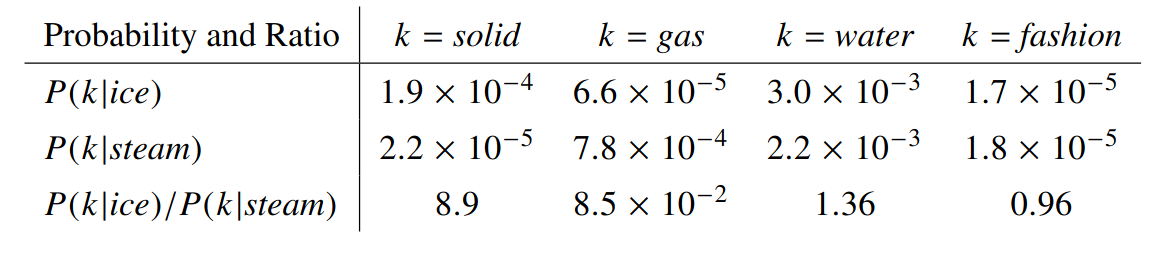

The function that we are modeling is: 

$F(w_i, w_j, \bar{w}_k) = \frac{P_{ik}}{P_{jk}}$, 

where $w$ are vector word $w \in R^{d}$ while $\bar{w} \in R^{d}$ is the context word. This function will be rewritten in order to create the Loss function: 

$J = \sum^{V}_{i,j=1} f (X_{ij}) ( w^T_i \cdot \bar{w}_j + b_i + \bar{b}_j - log X_{ij} )$

 

the function $ f (X_{ij}) $ is a weightening function defined as:

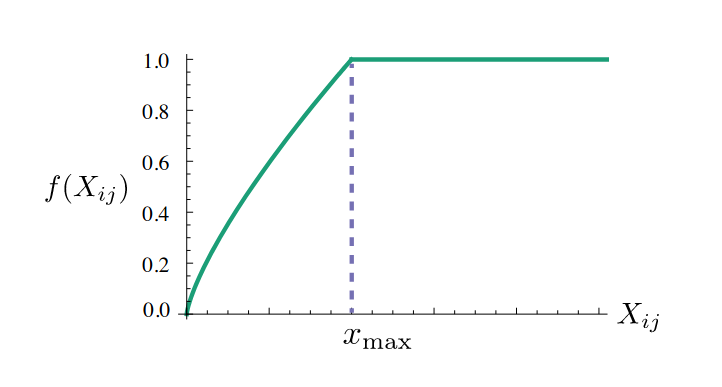

In [29]:
path_dir = os.getcwd()

config = yaml.safe_load(open(f'../config/config_glove.yml'))
config_name = 'glove_wiki_ita_custom'

EMBED_DIM = config[config_name]["EMBED_DIM"]
N_EPOCHS = config[config_name]["N_EPOCHS"]
BATCH_SIZE = config[config_name]["BATCH_SIZE"]
X_MAX = config[config_name]["X_MAX"]
ALPHA = config[config_name]["ALPHA"]
LEARNING_RATE = config[config_name]["LEARNING_RATE"]
# READ and pre-process the file 
file_name = 'file.txt'
path_text_file = f'../dataset/{file_name}'

##############################################################
dataset = gl.GloveDataset(open(path_text_file).read(), 100000)
glove = gl.GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cpu()

# of words: 100000
Vocabulary length: 16622


In [34]:
name_model = f'glove_ita_{config_name}'
path_saving_model = f'../results/model/{name_model}.pt'

optimizer = optim.Adagrad(glove.parameters(), lr = LEARNING_RATE)

n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = gl.weight_func(x_ij, X_MAX, ALPHA)
        loss = gl.wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), path_saving_model)

Epoch: 1/5 	 Batch: 100/292 	 Loss: 0.04813102558255196
Epoch: 1/5 	 Batch: 200/292 	 Loss: 0.04021023567765951
Saving model...
Epoch: 2/5 	 Batch: 100/292 	 Loss: 0.02274687113240361
Epoch: 2/5 	 Batch: 200/292 	 Loss: 0.021181746758520602
Saving model...
Epoch: 3/5 	 Batch: 100/292 	 Loss: 0.016581557830795644
Epoch: 3/5 	 Batch: 200/292 	 Loss: 0.016569827729836107
Saving model...
Epoch: 4/5 	 Batch: 100/292 	 Loss: 0.013578348373994232
Epoch: 4/5 	 Batch: 200/292 	 Loss: 0.013927631638944149
Saving model...
Epoch: 5/5 	 Batch: 100/292 	 Loss: 0.012146681919693947
Epoch: 5/5 	 Batch: 200/292 	 Loss: 0.012429696042090654
Saving model...


/home/mypc/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


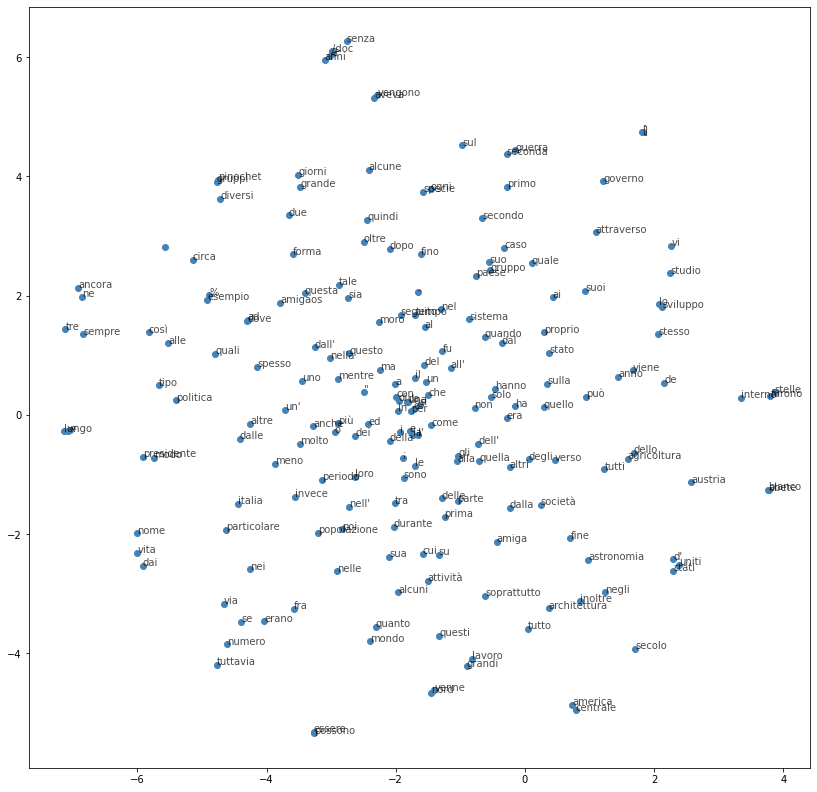

In [37]:
# Display word embeddings 

emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 200
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
